In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import shutil
import os

In [3]:
os.chdir('./CSV')

In [4]:
#content = Path.iterdir(Path.cwd())

for file in content:
    old_filename = file.name
    if 'olist_' in old_filename:
        new_filename = old_filename.replace('olist_', '').replace('_dataset', '')
        shutil.move(old_filename, new_filename)

In [5]:
content = Path.iterdir(Path.cwd())

In [6]:
dataframes = {}
for file in content:
    if file.is_file():
        dataframes[file.stem] = pd.read_csv(file.name)

In [7]:
print(*dataframes.keys(), sep='\n')

customers
geolocation
orders
order_items
order_payments
order_reviews
products
product_category_name_translation
sellers


# Dataframe shapes

In [9]:
for name, df  in dataframes.items():
    print(f'{name}. Shape: {df.shape}')

customers. Shape: (99441, 5)
geolocation. Shape: (1000163, 5)
orders. Shape: (99441, 8)
order_items. Shape: (112650, 7)
order_payments. Shape: (103886, 5)
order_reviews. Shape: (100000, 7)
products. Shape: (32951, 9)
product_category_name_translation. Shape: (71, 2)
sellers. Shape: (3095, 4)


## 1: What is the total revenue generated by Olist, and how has it changed over time?

In [91]:
df_orders = dataframes['orders']
df_items = dataframes['order_items']

### Orders dataframe contains dates. Let's check if the dtype is correct

In [92]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [93]:
date_cols = 'order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date'.split(', ')
date_cols

['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [94]:
for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [95]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

### order_items dataframe contains dates. Let's check if the dtype is correct

In [96]:
df_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [97]:
df_items.shipping_limit_date = pd.to_datetime(df_items.shipping_limit_date)

# <span style='color:red'>TODO: check if datasets are clean</span>

In [98]:
df_revenues = pd.merge(left=df_orders, right=df_items, on='order_id', how='left')

In [99]:
df_revenues.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value'],
      dtype='object')

In [100]:
df_revenues.duplicated().sum()

0

In [101]:
revenues_by_order = df_revenues.groupby('order_id')['price'].sum(numeric_only=True).to_frame()
revenues_by_order = revenues_by_order.rename(columns = {'price': 'revenue'})

In [102]:
revenues_by_order

,revenue
order_id,
00010242fe8c5a6d1ba2dd792cb16214,58.90
00018f77f2f0320c557190d7a144bdd3,239.90
000229ec398224ef6ca0657da4fc703e,199.00
00024acbcdf0a6daa1e931b038114c75,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...
fffc94f6ce00a00581880bf54a75a037,299.99
fffcd46ef2263f404302a634eb57f7eb,350.00
fffce4705a9662cd70adb13d4a31832d,99.90


In [103]:
total_revenues = revenues_by_order.sum()
total_revenues

revenue    13591643.7
dtype: float64

## Working with purchase dates

In [108]:
dates = df_revenues.order_approved_at.dt.date
dates = dates[dates.notnull()]

In [109]:
dates.min(), dates.max()

(datetime.date(2016, 9, 15), datetime.date(2018, 9, 3))

The oldest order was made on 2016 and the latest on 2018.

I will aggregate the orders by quarters.

In [117]:
quarterly_revenue = df_revenues.set_index('order_approved_at')

In [118]:
quarter_total_revenue = quarterly_revenue.resample('3M', closed='left').price.sum().to_frame()
quarter_total_revenue = quarter_total_revenue.rename(columns = {'price' : 'total_revenue'})
quarter_total_revenue.index.name = 'quarter_date'
quarter_total_revenue

,total_revenue
quarter_date,
2016-11-30,49775.02
2017-02-28,351653.68
2017-05-31,1226090.95
2017-08-31,1494439.01
2017-11-30,2280243.60
2018-02-28,2528203.39
2018-05-31,3010811.75
2018-08-31,2648610.87
2018-11-30,145.00


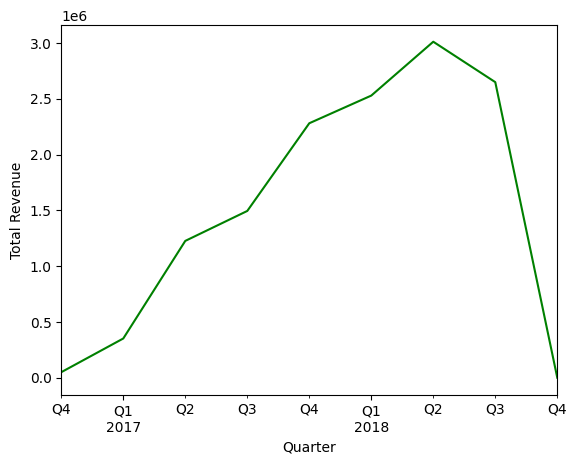

In [121]:
fig, ax = plt.subplots()
quarter_total_revenue.plot.line(color='green', ax = ax, legend=False)
ax.set_xlabel('Quarter')
ax.set_ylabel('Total Revenue')
plt.show()

## 2: How many orders were placed on Olist, and how does this vary by month or season?

In [124]:
valid_orders = df_orders[df_orders['order_status'] != 'canceled']

Number of orders placed by Olist:

In [125]:
valid_orders.order_id.nunique()

98816

In [126]:
df2 = valid_orders.set_index('order_approved_at')

In [127]:
orders_placed_monthly = df2.resample('M', closed='left').order_id.count()

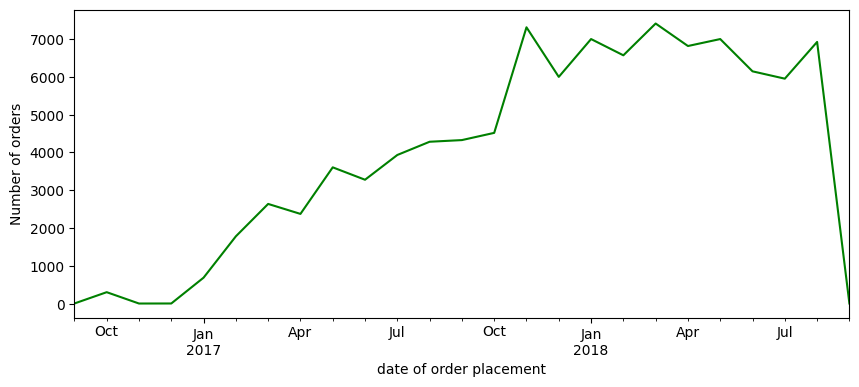

In [128]:
fig, ax = plt.subplots(figsize=(10,4))
orders_placed_monthly.plot.line(ax=ax, color='green')
ax.set_xlabel('date of order placement')
ax.set_ylabel('Number of orders')
plt.show()

## 3: What are the most popular product categories on Olist, and how do their sales volumes compare to each other?

In [131]:
df_items = dataframes['order_items']

In [132]:
df_items.sample(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
55111,7d521825cd606cb527aba4acc1943457,1,3cb39171fd36c50097f2dedbbe0dfe6e,16090f2ca825584b5a147ab24aa30c86,2018-04-20 19:35:14,28.49,18.23
25733,3a781a72374ad22c36cc60ffdbcc9b98,1,83a6fc0d9871efceb01cb3c20c510017,f0b47fbbc6dee9aafe415a6e33051b3f,2018-06-21 19:31:44,39.97,16.47
19014,2bae46553a029f4e6c9976e173d676ef,1,19c91ef95d509ea33eda93495c4d3481,06a2c3af7b3aee5d69171b0e14f0ee87,2018-06-13 03:50:18,122.99,84.41
20765,2f864e4c1471571ec2ea1476fa2ba42c,1,ccadfeab525a9eb1569983b66e5075c4,33576ec5412fb5905d876f12f33bfde6,2018-05-23 15:31:56,89.00,19.31
110719,fb8e4428d340ab5bfa482ef6fc97efbc,4,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2017-09-08 08:44:16,169.90,12.69


In [133]:
df_products = dataframes['products']

In [134]:
df_products.sample(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
29292,9b1de4de04403b36408237b1cb77efbb,relogios_presentes,57.0,491.0,2.0,250.0,16.0,11.0,11.0
32676,8adb806e404876383ce47845af3ddcb8,livros_tecnicos,45.0,1423.0,1.0,600.0,27.0,2.0,21.0
4458,001b237c0e9bb435f2e54071129237e9,cama_mesa_banho,42.0,253.0,1.0,6000.0,40.0,4.0,30.0
28187,3190be5a1932c6aeece81e7adcd310aa,esporte_lazer,51.0,1549.0,1.0,240.0,16.0,2.0,11.0
15073,4650fae75d852ddfada4751f6f02481a,perfumaria,30.0,138.0,1.0,100.0,20.0,5.0,20.0


In [141]:
df_translation = dataframes['product_category_name_translation']
df_translation

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [207]:
df = pd.merge(df_orders, df_items, on='order_id', how='left')
df = pd.merge(df, df_products, on='product_id', how='left')
df = pd.merge(df, df_translation, on='product_category_name', how='left')

In [208]:
df.sample().T

,74056
order_id,2f80a0b08926b808eafcaa9ceb2e7af4
customer_id,01122215dd21ac872ae567ec4e351e01
order_status,delivered
order_purchase_timestamp,2018-04-13 18:16:52
order_approved_at,2018-04-14 02:13:28
order_delivered_carrier_date,2018-04-17 00:54:50
order_delivered_customer_date,2018-04-17 16:31:40
order_estimated_delivery_date,2018-05-02 00:00:00
order_item_id,1.0
product_id,018ca97302e4293050cc41413194bb19


In [201]:
categories= df[['order_id', 'product_id', 'price', 'product_category_name_english']]

In [202]:
categories_count = categories.groupby('product_category_name_english').agg({'order_id': 'count', 'price' : sum}).sort_values('order_id', ascending=False)
categories_count = categories_count.rename(columns = {'order_id': 'total_units_ordered', 'price': 'total_revenue'})
categories_count.index = [i.replace('_', ' ').strip() for i in categories_count.index]

In [203]:
categories_count

,total_units_ordered,total_revenue
bed bath table,11115,1036988.68
health beauty,9670,1258681.34
sports leisure,8641,988048.97
furniture decor,8334,729762.49
computers accessories,7827,911954.32
...,...,...
arts and craftmanship,24,1814.01
la cuisine,14,2054.99
cds dvds musicals,14,730.00
fashion childrens clothes,8,569.85


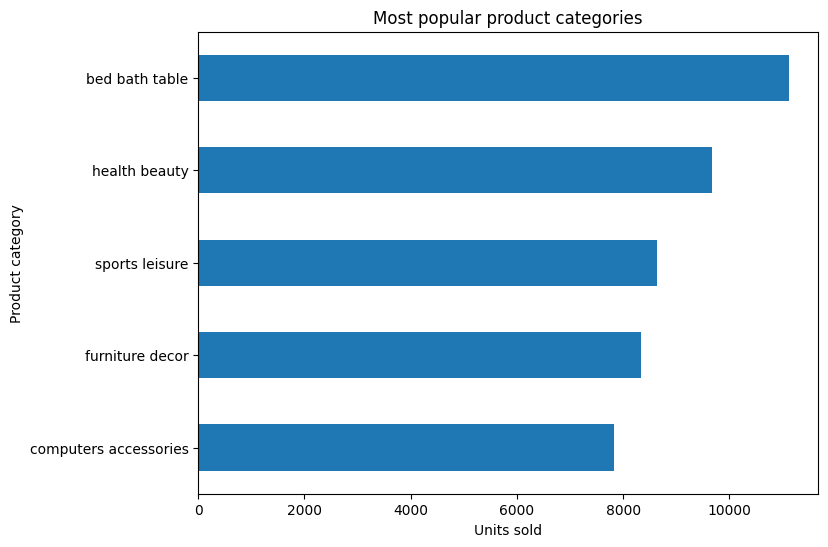

In [204]:
fig, ax = plt.subplots(figsize=(8,6))
data = categories_count.total_units_ordered[:5].sort_values(ascending=True)
data.plot.barh()
ax.set_xlabel('Units sold')
ax.set_ylabel('Product category')
ax.set_title('Most popular product categories')
plt.show()

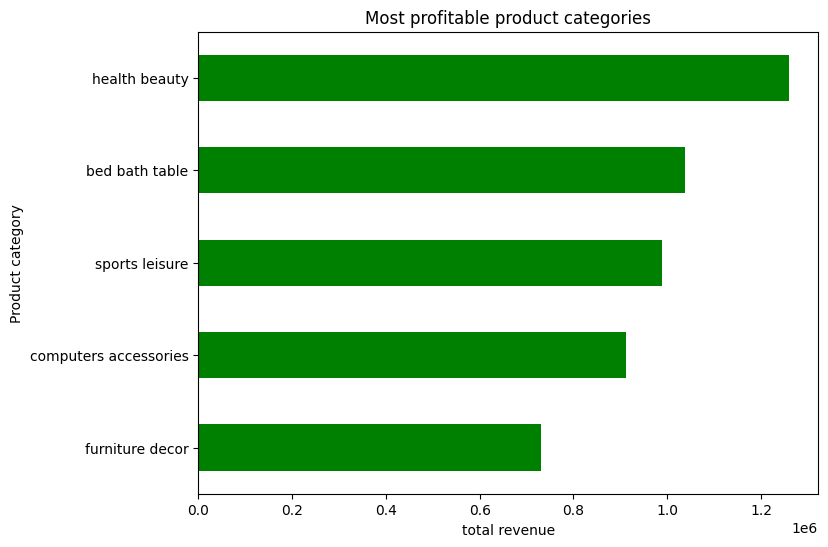

In [205]:
fig, ax = plt.subplots(figsize=(8,6))
data = categories_count.total_revenue[:5].sort_values()
data.plot.barh(color='green')
ax.set_xlabel('total revenue')
ax.set_ylabel('Product category')
ax.set_title('Most profitable product categories')
plt.show()

## 4: What is the average order value (AOV) on Olist, and how does this vary by product category or payment method?

Average order value is:

In [206]:
round(revenues_by_order.mean(), 2)

revenue    136.68
dtype: float64

In [225]:
order_mean_by_prod_category = df.groupby('product_category_name_english').price.mean().round(2).sort_values(ascending=False)
order_mean_by_prod_category

product_category_name_english
computers                                1098.34
small_appliances_home_oven_and_coffee     624.29
home_appliances_2                         476.12
agro_industry_and_commerce                342.12
musical_instruments                       281.62
                                          ...   
food_drink                                 54.60
cds_dvds_musicals                          52.14
diapers_and_hygiene                        40.19
flowers                                    33.64
home_comfort_2                             25.34
Name: price, Length: 71, dtype: float64

In [229]:
revenues_by_payment_method = df_revenues[['order_id', 'order_status', 'price']]

In [231]:
revenues_by_payment_method = revenues_by_payment_method.merge(dataframes['order_payments'], on='order_id', how ='left') 

In [236]:
revenues_by_payment_method = revenues_by_payment_method.drop(['payment_sequential', 'payment_installments'], axis=1)

In [240]:
revenues_by_payment_method = revenues_by_payment_method[revenues_by_payment_method.order_status != 'canceled']

In [241]:
revenues_by_payment_method.columns

Index(['order_id', 'order_status', 'price', 'payment_type', 'payment_value'], dtype='object')

In [257]:
average_revenue_by_pay_method = revenues_by_payment_method.groupby('payment_type').price.mean().sort_values(ascending=False).round(2)
average_revenue_by_pay_method.index = [i.replace('_', ' ') for i in average_revenue_by_pay_method.index ]

In [258]:
average_revenue_by_pay_method

credit card    126.21
debit card     107.56
voucher        104.55
boleto         104.41
Name: price, dtype: float64

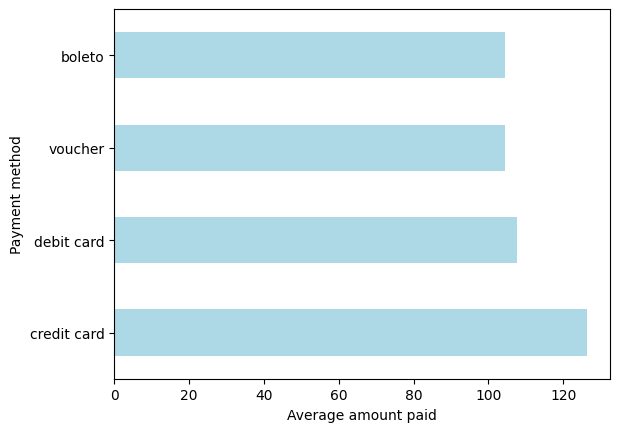

In [259]:
fig,ax = plt.subplots()
average_revenue_by_pay_method.plot.barh(color='lightblue', ax=ax)
ax.set_xlabel('Average amount paid')
ax.set_ylabel('Payment method')
plt.show()